# Procesamiento de Señales de Audio en Musica

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display  import Audio

# Introducción

[En que consiste el proyecto]

Para un trabajo "tradicional" de Machine Learning, lo que habitualmente se hace es obtener todas las características del audio posibles tanto del dominio temporal como frecuencial y luego se escogen las que se cree que son más útiles para el trabajo que se está realizando. 

# Fundamentos teóricos

[En que consiste la sección]

## Características de dominio temporal

La producción de sonido hace que las moléculas de aire circundantes vibren, manifestándose en regiones alternas de compresión (alta presión) y rarefacción (baja presión). Estas compresiones y rarefacciones viajan a través del medio y llegan a nuestros oídos, permitiéndonos percibir el sonido tal como es. Por lo tanto, la propagación del sonido implica la transmisión de estas variaciones de presión a lo largo del tiempo. 

La representación en el dominio del tiempo del sonido implica capturar y analizar estas variaciones de presión en diferentes intervalos de tiempo mediante el muestreo de la onda de sonido en puntos discretos en el tiempo. Cada muestra representa el nivel de presión del sonido en un momento específico. Al trazar estas muestras, obtenemos una forma de onda que muestra cómo cambia el nivel de presión del sonido con el tiempo.

Podemos representar esta onda (o señal analógica) con dos ejes. El eje horizontal representa el tiempo, mientras que el eje vertical representa la amplitud o intensidad del sonido, generalmente escalada para ajustarse entre -1 y 1, donde los valores positivos indican compresión y los valores negativos indican rarefacción.

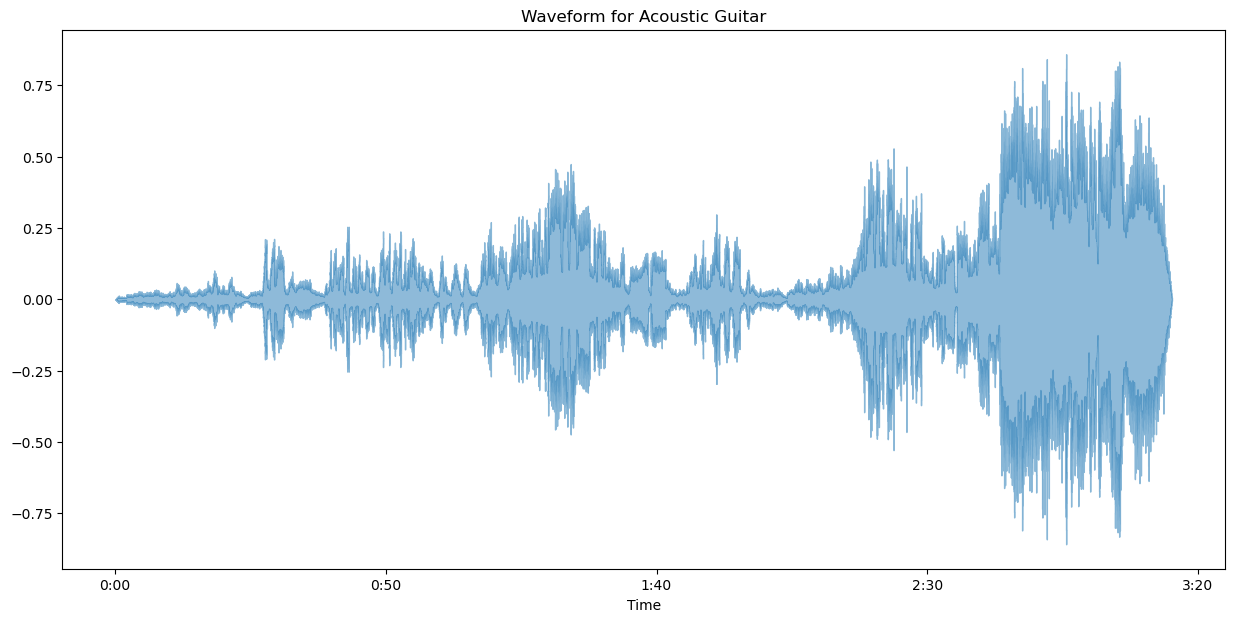

In [3]:
cancion_op = "data/opera/NessunDorma_Opera.mp3"
# nessun: array con los valores de la amplitud en distintos intervalos temporales
# sr (_): tasa de muestro
nessun, sr = librosa.load(cancion_op)
Audio(cancion_op)

def show_waveform(signal, name=""):
    # Create a new figure with a specific size
    plt.figure(figsize=(15, 7))
    # Display the waveform of the signal using librosa
    librosa.display.waveshow(signal, alpha=0.5)
    # Set the title of the plot
    plt.title("Waveform for " + name)
    # Show the plot
    plt.show()

show_waveform(nessun, "Acoustic Guitar")

Para procesar y almacenar estas señales analógicas de manera digital, se deben convertir en una representación discreta. Aquí es donde entra el muestreo para capturar capturas de pantalla de la onda de sonido en intervalos de tiempo discretos y uniformemente espaciados. La tasa de muestreo determina con qué frecuencia se toman muestras de la señal analógica y se mide en muestras por segundo o hertzios (Hz). 

Una tasa de muestreo más alta significa una representación más precisa pero requiere más recursos de memoria, mientras que una tasa de muestreo más baja significa una representación menos precisa pero requiere menos recursos de memoria.

Al elegir una tasa de muestreo adecuada para la conversión analógica a digital, es importante conocer el teorema de muestreo de Nyquist-Shannon. Este teorema establece que, para capturar y reconstruir con precisión una señal analógica y evitar el _aliasing_, la tasa de muestreo ($F_m$) debe ser al menos el doble de la frecuencia más alta presente en la señal de audio ($f_{max}$), conocida como la Tasa/Frecuencia de Nyquist ($N_f$).

$$F_m \geq N_f = \frac{f_{max}}{2}$$

Hablemos de dos parámetros cruciales para extraer características: el tamaño del marco (_frame length_) y la longitud de salto (_hop length_). Después de procesar una señal, se divide en marcos con cierto tamaño y superposición. Esto es esencial para capturar la variación temporal en las características de la señal. Los métodos tradicionales de extracción de características dan un solo número como resumen, pero esto borra la información temporal. La solución es dividir la señal en marcos, calcular características como la media para cada marco y obtener un resumen de características dependiente del tiempo.

-  Tamaño del Marco (_Frame_): Describe el tamaño de cada marco. Si por ejemplo trabajamos con una frecuencia de muestreo de 44.1 Hz (frecuencia típica en los CD rom), cada sample equivale a 0.0227ms, un número mucho menor que la resolución temporal propia de los humanos (alrededor de 10ms). Con los _frames_ se pretenede obtener la suficiente duración temporal para apreciar los eventos acústicos. Por ejemplo, si el tamaño del marco es 1024, lo equivalente a un intervalo temporal de 23.245ms para una frecuencia de muestreo de 44.1 Hz, incluyes 1024 muestras en cada marco y calculas las características necesarias para cada conjunto de estas 1024 muestras. En general, se recomienda que el tamaño del marco sea una potencia de 2. La razón detrás de esto es porque la Transformada Rápida de Fourier requiere que los marcos tengan un tamaño que sea una potencia de 2.

- Longitud de Salto: Se refiere al número de muestras por el cual se avanza un marco en cada paso a lo largo de la secuencia de datos, es decir, el número de muestras que desplazamos hacia la derecha antes de generar un nuevo marco. La longitud de salto, por lo tanto, determina la superposición entre marcos de audio consecutivos. 

Para mitigar el impacto de un fenómeno llamado "fuga espectral", que ocurre al convertir una señal de su dominio de tiempo a su dominio de frecuencia y que produce componentes de alta frecuencia no presentes en la señal original, se aplica una función de ventana a cada marco, multiplicando la señal por la función ventana correspondiente sobre el marco, lo que resulta en la pérdida de datos alrededor de los bordes de cada marco. Por lo tanto, a menudo se eligen longitudes de salto intermedias para preservar las muestras en los bordes, lo que resulta en diferentes grados de superposición entre marcos. Una de las funciones ventana más conocida es la función de Hann que se define como sigue:

$$w(k) = 0.5 \cdot (1-cos(\frac{2\pi k}{K-1})), k=1...K$$

[Introducir imagenes explicatorias? (Frame length, Hop length, windowing)]

Previamente a la definición matemática de algunas características, aclaramos ciertas notaciones:

- $x_i$ : amplitud en la muestra $i$.
- $x(t)$: amplitud en el instante $t$.
- $K$ : tamaño de un _frame_ en muestras.
- $H$ : tamaño de un salto entre _frames_.

### Amplitude Envelope

En español, la envolvente de una señal, es simplemente el valor máximo de la amplitud en cierto intervalo de tiempo (_frame_). Esta característica nos proporciona una idea aproximada sobre el volumen de la señal. Un problema del AE es que es sensible a los outliers. Matemáticamente, podemos definir el envolvente de la amplitud del _frame_ k-ésimo como:

$$AE_k = max^{(k+1) \cdot K-1}_{i=k \cdot K} x_i$$

Algunas de las aplicaciones de esta característica son:
- Onset detection: detectar el inicio de una nota musical, una palabra, o un evento sonoro en general...
- Clasificacion por genero musical

Extracción: https://www.youtube.com/watch?v=rlypsap6Wow&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=8

### Root-Mean Square Energy (RMS)

La energía $E$ de una señal continua se define como el area bajo la magnitud al cuadrado de la señal. Para señales de audio equivale a como de alto suena la señal. Para una señal contínua en un intervalo de tiempo $T$ se define como $$E_c=\int_{0}^{T} |x(t)|^2$$
Y para una señal discreta con K muestras $$E_d = \sum_{i=1}^K |x_i|^2$$

El root-mean-square energy (RMS), o valor eficaz, es otra medida importante en el análisis de señales. Se calcula tomando la raíz cuadrada del valor promedio de la energía de la señal. Para una señal continua x(t) en un intervalo de tiempo $T$, el RMSE se calcula de la siguiente manera:

$$RMS = \sqrt{\frac{1}{T}E_c}$$

En el caso de una señal discreta con K muestras, el RMS se calcula como:

$$RMS = \sqrt{\frac{1}{K}E_d}$$

El RMS es útil porque proporciona una medida de la "amplitud efectiva" de la señal. Mientras que la amplitud pico da la magnitud máxima de la señal, el RMS tiene en cuenta la magnitud de todos los valores y proporciona una medida más representativa de la energía o potencia de la señal. En el caso de señales sinusoidales, el valor RMS es directamente proporcional a la amplitud de la señal.

Algunas de las aplicaciones de esta característica son:
- Segmentación de audio
- Clasificacion por genero musical

A continuación obtenemos el RMS de la canción "Nessun Dorma" para un tamaño de frame de 1024 y con un salto de 512.

In [32]:
# Extract RMSE
FRAME_LENGTH = 1024
HOP_LENGTH = 512

rms_nessun = librosa.feature.rms(y=nessun, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

Text(0.5, 1.0, 'Nessun dorma Waveform (blue) & RMS (red)')

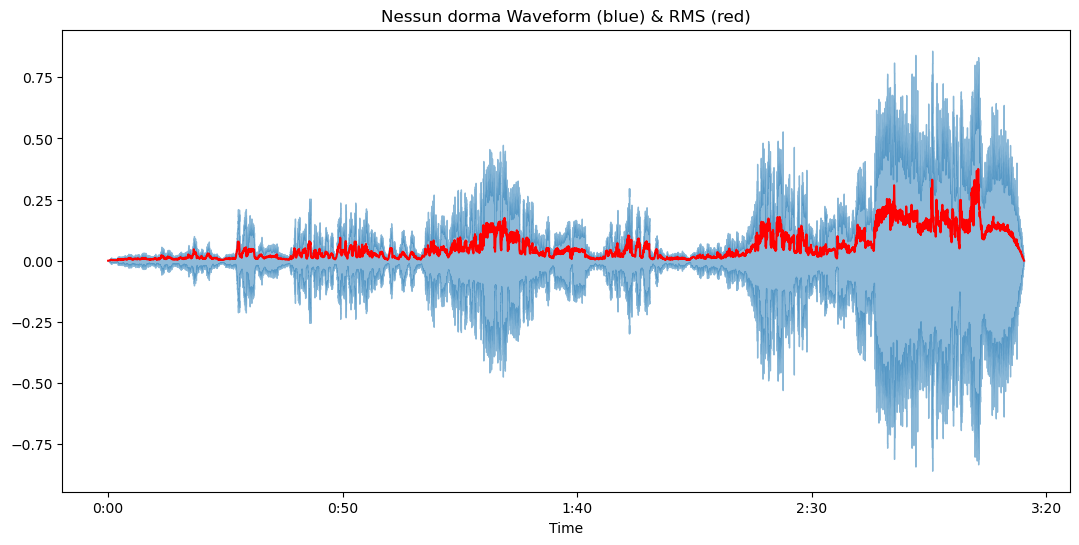

In [33]:
# Plot RMSE
frames = range(len(rms_nessun))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize=(13,6))

librosa.display.waveshow(nessun, alpha=0.5)
plt.plot(t, rms_nessun, color='r')
plt.title('Nessun dorma Waveform (blue) & RMS (red)')

En rojo podemos ver el RMSE sobre la forma de onda de la canción. Se puede observar como presenta mucha menos variabilidad que la onda original. Como hemos mencionado previamente, esto es debido a que el RMS considera todos los valores de la señal y no únicamente el máximo.

### Tasa de cruces con cero (ZCR)

Tasa de cruces con cero: es la tasa de cambios de signo a lo largo de una señal, es decir, la tasa a la que la señal cambia de positivo a cero a negativo o de negativo a cero a positivo. Esta función se ha utilizado mucho tanto en el reconocimiento de voz como en la recuperación de información musical, siendo una función clave para clasificar los sonidos de percusión.

La tasa de cruces con cero (ZCR) se define formalmente como:

$$ ZCR = \frac{1}{K-1} \sum_{i=1}^{K-1} 1_{\mathbb{R} < 0}(x_i \cdot x_{i-1}) $$

Donde:
- $ 1_{\mathbb{R} < 0}(x_i \cdot x_{i-1}) $ es una función indicadora que toma el valor de 1 si $ x_i \cdot x_{i-1} $ es negativo (indicando un cambio de signo), y 0 en caso contrario.
- La suma se realiza sobre todos los tiempos $i$ desde 1 hasta K-1 .
- La división por $K-1$ normaliza la suma para obtener la tasa promedio de cruces con cero por unidad de tiempo.

Algunas de las aplicaciones de esta característica son:
- Reconocimiento de sonidos agudos (bajo ZCR) vs percusión (alto ZCR)
- Estimación de tono monofónico (nota)
- Detectar si una señal contiene voz o no
- Clasificacion por genero musical


In [23]:
FRAME_LENGTH = 1024
HOP_LENGTH = 512

zcr_nessun = librosa.feature.zero_crossing_rate(y=nessun, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

Text(0.5, 1.0, 'Nessun dorma ZCR')

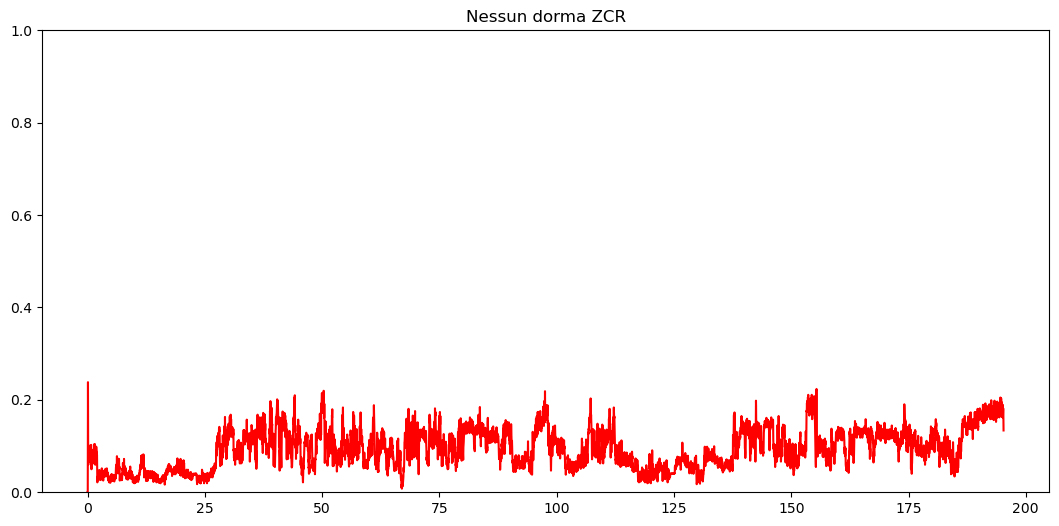

In [34]:
# Plot ZCR normalizado
frames = range(len(zcr_nessun))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize=(13,6))
plt.plot(t, zcr_nessun, color='r')
# Los valores del ZCR normalizados con el tamaño del frame
plt.ylim((0,1))
plt.title('Nessun dorma ZCR')

Text(0.5, 1.0, 'Nessun dorma ZCR')

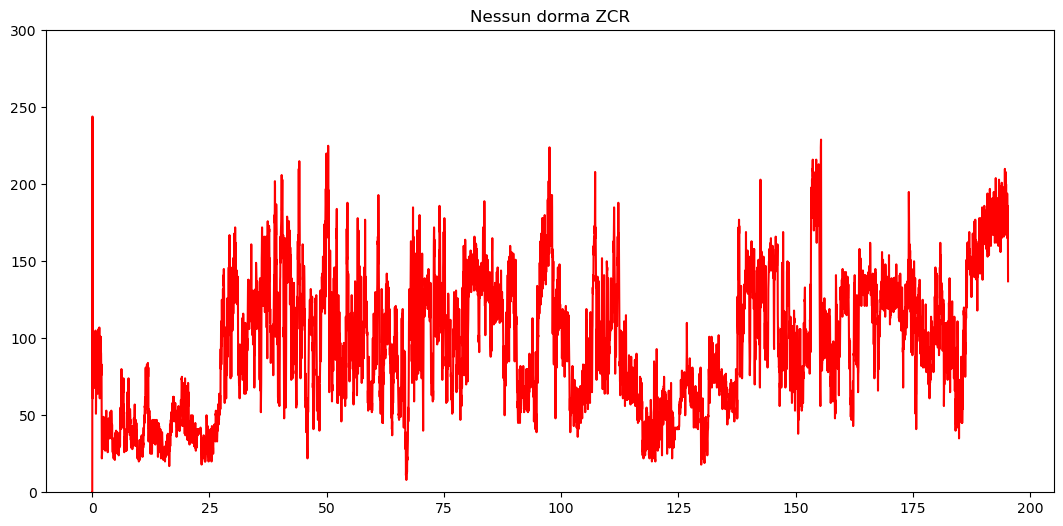

In [36]:
# Plot ZCR sin normalizar
plt.figure(figsize=(13,6))
plt.plot(t, zcr_nessun * FRAME_LENGTH, color='r')
# Los valores del ZCR sin normalizar con el tamaño del frame
plt.ylim((0,300))
plt.title('Nessun dorma ZCR')

Nota: normalmente la musica rock tiene un zcr alto respecto a otros generos como la música clasica debido a los **intrumentos de percusión**.

Nota: Vemos que el eje de las x se corresponden a los segundos de la canción (195)

### Crest Factor

## Características de dominio frecuencial (spectrum)

### Spectrum (Transformada de Fourier)

Aplicando la transformada de fourier a la señal en dominio temporal, obteniendo la señal represantada en el dominio frecuencial

### Band Energy Ratio

### Spectral Centroid

Es una medida utilizada en el procesamiento de señales digitales para caracterizar un espectro. Indica dónde se encuentra el centro de masa del espectro. Perceptualmente, tiene una conexión robusta con la impresión de brillo de un sonido.

Se calcula como la media ponderada de las frecuencias presentes en la señal, determinada mediante una transformada de Fourier, con sus magnitudes como ponderaciones:

$$ Centroide= \frac{\sum_{n=0}^{N-1} f(n)x(n)} {\sum_{n=0}^{N-1} x(n)} $$

donde x (n) representa el valor de frecuencia ponderado, o magnitud, del número de intervalo n , y f (n) representa la frecuencia central de ese intervalo.

### Spectral Bandwidth

Ancho de banda espectral: El ancho de banda espectral se define como el ancho de la banda de luz a la mitad del pico máximo (o ancho completo a la mitad del máximo [FWHM]) y se representa por las dos líneas rojas verticales y λSB en el eje de longitud de onda. Ancho de rendija espectral, un término relacionado al que se hace referencia con frecuencia en Regulaciones EP, se define como la extensión total de longitudes de onda representado por las líneas azules y λSSW. El ancho de banda espectral del instrumento siempre será más estrecho que el ancho de la rendija espectral.

El ancho de banda espectral de un espectrofotómetro está relacionado con el ancho de rendija física del monocromador y, por tanto, a las capacidades de resolución del instrumento.

### Spectral Flatness

### Spectral Flux

### Frecuencia Cromática

Frecuencia cromática: se relaciona estrechamente con las doce clases de tonos diferentes. Las características basadas en croma, que también se conocen como “ perfiles de clase de tono “, son una herramienta poderosa para analizar música cuyos tonos se pueden categorizar de manera significativa (a menudo en doce categorías) y cuya afinación se aproxima a la escala de temperamento igual. Una propiedad principal de las características cromáticas es que capturan las características armónicas y melódicas de la música, al tiempo que son resistentes a los cambios en el timbre y la instrumentación.

## Características de dominio temporal-frecuencial (spectrograma)

### Spectogram (Short Time Fourier Transform)

El espectrograma (time-freq 2d) se obtiene aplicando la Short Time Fourier Transform a la representación time-freq de la señal [...]

Cuando aplicamos la transformada discreta de fourier obtenemos las frecuencias que componen la señal original. El problema que surje es que conocemos "el que" pero no "el cuando", es decir, no conocemos que frecuencias están presentes en un intervalo de tiempo concreto. La idea general para resolver el problema planteado anteriormente es considerar pequeños segmentos de la señal (_frames_) y aplicar FFT (del inglés, _Fast Fourier Transform_) a cada uno de ellos.  Como se ha mecionó previamente, con el objetivo de evitar el _Spectral Leakage_, se aplica una función ventana al trozo de señal contenido en el _frame_ previamente a la FFT con cierto numero de _samples_ de la señal superpuestas en cada frame con tal de evitar la pérdida de información. Esto es lo que se conoce como STFT (del inglés, _Short-Time Fourier Transform_). La formulación matemática de la STFT es:

$$S(m,k) = \sum_{n=0}^{N-1}x(n+mH) \cdot w(n) \cdot e^{-i2\pi m \frac{k}{N}}$$

donde:
- $n$ es el sample
- $m$ es el frame
- $k$ es la frecuencia
- $N$ es el tamaño del _frame_
- $H$ es el tamaño de salto
- $w(n)$ es la función ventana 

Como podemos ver se obtiene un resultado en función del tiempo $(m)$ y la frecuencia $(k)$. En otras palabras, el resultado de aplicar la DFT a la señal modificada por la función ventana para la frecuencia $k$ en el frame $m$. La función ventana empleada típicamente es la ventana de Hann. Mientras que en la DFT el número de valores que puede tomar $k$ (frecuencias evaluadas) es igual al número de _samples_ de la señal, en la STFT no se consideran la mitad de las frecuencias posibles por el efecto "espejo" (simetría entorno a la frecuencia de Nyquist) obtenido en el resultado de la DFT. Por lo tanto, $k$ tomará valores hasta $\frac{Tamaño frame}{2}+1$. 

Como el resultado de la DFT contiene coeficientes complejos (con componente imaginaria), a la hora de visualizar el resultado se aplica la transformación $Y(m,k) = |S(m,k)|^2$. Posteriormente se transforma de una representación linear de la amplitud a decibelios (dB) mediante $10*log_{10}(Y)$ para poder interpretar el resultado mediante un _heatmap_, ya que la forma que tenemos los humanos de percibir las frecuencias no es linear, sino logaritmica.

Un aspecto importante a considerar es que un tamaño grande de _frame_ aumenta la resoluciñon frecuencial pero disminuye la resolución temporal. De forma adversa, un tamaño de frame menor, disminuye la resolución frecuencial y aumenta la temporal. Es decir, para localizar fenómenos breves se emplean tamaños de frame pequeños y para localizar frecuencias de forma más nítida se emplean tamaños de frame grandes. Esto es debido a que la resolución temporal y la frecuencial son inversamente proporcionales, es decir, al aumentar el tamaño de frame evaluamos más frecuencias posibles pero en un intervalo de tiempo mayor. Esto es lo que se conoce como principio de incertidumbre.

DIFERENCIAS EN ESPECTOGRAMA DE CANCIONES DE DISTINTO GENERO
Minuto 19:25 de https://www.youtube.com/watch?v=3gzI4Z2OFgY&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=16

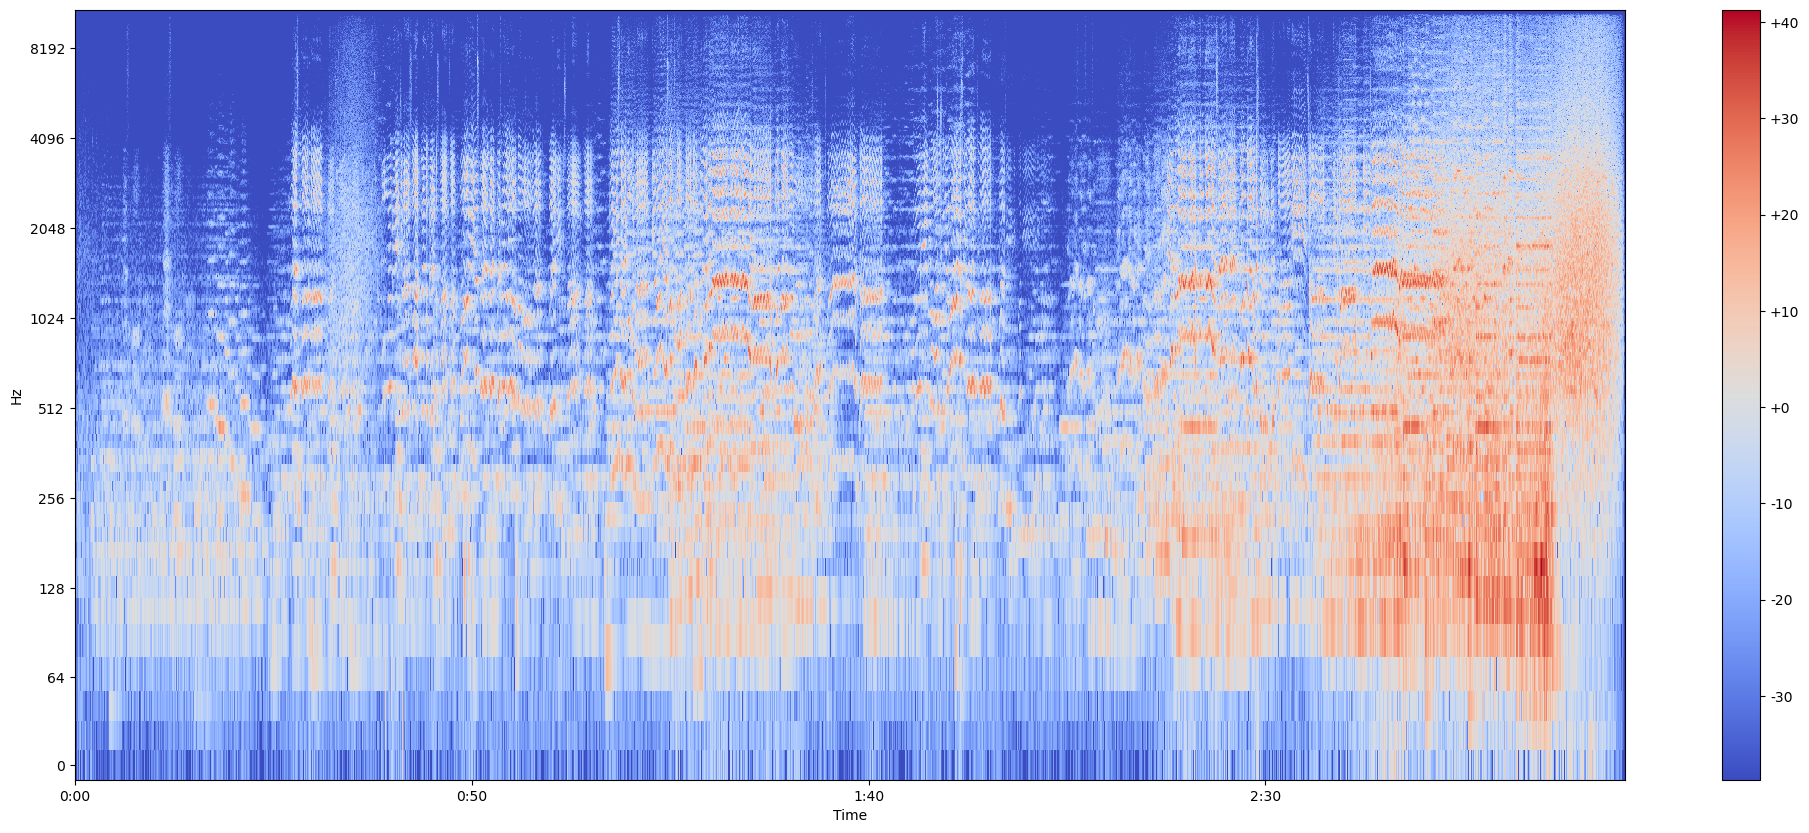

In [10]:
FRAME_LENGTH = 1024
HOP_LENGTH = 512

# STFT
S = librosa.stft(nessun, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)

# Espectograma
Y = np.abs(S) ** 2

# Transformar a escala logaritmica
Y_log = librosa.power_to_db(Y)

def plot_spectogram(Y, sr, hop_length):
    plt.figure(figsize=(25,10))
    librosa.display.specshow(Y,
                             sr=sr,
                             hop_length=hop_length,
                             x_axis='time',
                             y_axis='log')
    plt.colorbar(format='%+2.f')

plot_spectogram(Y_log, sr, HOP_LENGTH)

### Mel-Frequency Cepstral Coefficients 

Cepstrum de Frecuencia Mel: el cepstrum de frecuencia mel ( MFC ) es una representación del espectro de potencia a corto plazo de un sonido, basado en una transformada de coseno lineal de un espectro de potencia logarítmica en una escala de frecuencia mel no lineal .

Los coeficientes cepstrales de frecuencia Mel ( MFCC ) son coeficientes que forman colectivamente un MFC. Se derivan de un tipo de representación cepstral del clip de audio (un “espectro de un espectro” no lineal). La diferencia entre el cepstrum y el cepstrum de frecuencia mel es que en el MFC, las bandas de frecuencia están igualmente espaciadas en la escala mel, lo que se aproxima más a la respuesta del sistema auditivo humano que las bandas de frecuencia espaciadas linealmente que se usan en el cepstrum normal. Esta deformación de frecuencia puede permitir una mejor representación del sonido, por ejemplo, en la compresión de audio.

Los MFCC se obtienen comúnmente de la siguiente manera:

Tomar la transformada de Fourier de (un extracto en ventana de) una señal.
Mapear las potencias del espectro obtenido anteriormente en la escala mel , utilizando ventanas triangulares superpuestas .
Tomar los registros de las potencias en cada una de las frecuencias mel.
Tomar la transformada de coseno discreta de la lista de potencias mel log, como si fuera una señal.
Los MFCC son las amplitudes del espectro resultante.
Puede haber variaciones en este proceso, por ejemplo: diferencias en la forma o el espaciado de las ventanas utilizadas para mapear la escala, o adición de características dinámicas como “delta” y “delta-delta” (primera y segunda -orden de diferencia trama a trama) coeficientes.

Los valores de MFCC no son muy robustos en presencia de ruido aditivo, por lo que es común normalizar sus valores en los sistemas de reconocimiento de voz para disminuir la influencia del ruido. Algunos investigadores proponen modificaciones al algoritmo básico de MFCC para mejorar la robustez, como elevar las amplitudes log-mel a una potencia adecuada (alrededor de 2 o 3) antes de tomar la DCT (Transformada de coseno discreta), que reduce la influencia de baja componentes energéticos.

### Otras ...

Más variables

Caída Espectral: Un extractor de características que extrae el punto de caída espectral. Esta es una medida de la cantidad de sesgo a la derecha del espectro de potencia.

El punto de caída espectral es la fracción de contenedores en el espectro de potencia en la que el 85% de la potencia se encuentra en frecuencias más bajas.

Tempograma: se refiere a la velocidad de una pieza musical. Más precisamente, el tempo se refiere a la frecuencia del ritmo musical y viene dado por el recíproco del período de tiempo. El tempo a menudo se define en unidades de latidos por minuto (BPM).

### Referencias

Frame rate, hop length, Amplitude envelope, RMSE, Crest Factor, ZCR, etc.
https://towardsdatascience.com/decoding-the-symphony-of-sound-audio-signal-processing-for-musical-engineering-c66f09a4d0f5#:~:text=Next%2C%20let's%20talk%20about%20the,amplitude%20values%20in%20a%20frame.
Link de github con el código del artículo anterior: https://github.com/namanlab/Audio-Signal-Processing-Feature-Extraction

Video RMSE y ZCR: https://www.youtube.com/watch?v=EycaSbIRx-0&t=36s